<a href="https://colab.research.google.com/github/GitanDas/Corrosion-Detection-Model/blob/main/Corrosion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Required Libraries

In [ ]:
# Install requirements
!pip install opencv-python==4.5.3.56
# !pip install Pillow==8.3.2
!pip install timm==0.4.12
!pip install python-multipart==0.0.5
!pip install uvicorn==0.15.0
!pip install pyngrok
!pip install nest-asyncio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR = 'drive/MyDrive/data'

Mounted at /content/drive


In [ ]:
import torchvision
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.transforms import ToTensor

In [ ]:
transformations_exp = transforms.Compose([
    transforms.Resize((256,256)),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
  ])

In [ ]:
dataset = ImageFolder(DATA_DIR, transform = transformations_exp)
print(dataset.classes)

['CORROSION', 'NOCORROSION']


In [ ]:
test_size = 300
train_size = len(dataset) - test_size
train_ds, test_ds = random_split(dataset, [train_size,test_size])
len(train_ds),len(test_ds)

(1519, 300)

In [ ]:
from torch.utils.data.dataloader import DataLoader
batch_size = 50

In [ ]:
train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle = True,
                      pin_memory = True)
test_dl = DataLoader(test_ds,
                     batch_size*2,
                     shuffle=False,
                     pin_memory = True)

In [ ]:
from torchvision.utils import make_grid
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize = (12,6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 10).permute(1,2,0))
        break

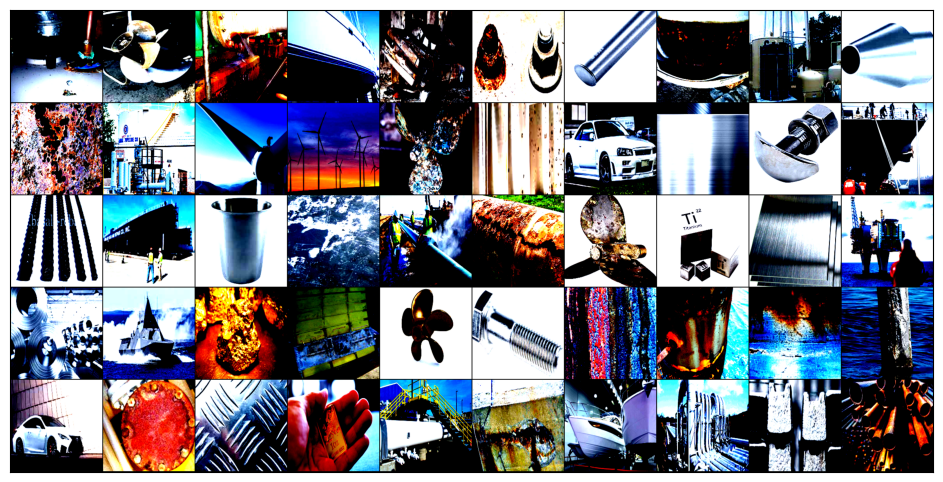

In [ ]:
show_batch(train_dl)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class Corrosion_Detection(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # imput : 3 x 224 x 224
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            # output : 32 x 224 x 224
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 112 x 112

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 56 x 56

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 28 x 28

            nn.Flatten(),
            nn.Linear(256*28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 2))

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = Corrosion_Detection()
model

Corrosion_Detection(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=200704, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(i

In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
model = model.to(device)

In [ ]:
@torch.no_grad()# The @ does not allow tracking of gradients
def evaluate(model, test_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, test_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Testing phase
        result = evaluate(model, test_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(Corrosion_Detection(), device)

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.0001

In [ ]:
history = fit(num_epochs, lr, model, train_dl, test_dl, opt_func)

Epoch [0], train_loss: 0.6350, val_loss: 0.5744, val_acc: 0.7100
Epoch [1], train_loss: 0.5643, val_loss: 0.5376, val_acc: 0.7467
Epoch [2], train_loss: 0.5307, val_loss: 0.4417, val_acc: 0.7867
Epoch [3], train_loss: 0.4575, val_loss: 0.3977, val_acc: 0.8233
Epoch [4], train_loss: 0.4413, val_loss: 0.3949, val_acc: 0.8233
Epoch [5], train_loss: 0.3492, val_loss: 0.5871, val_acc: 0.7233
Epoch [6], train_loss: 0.3344, val_loss: 0.3731, val_acc: 0.8300
Epoch [7], train_loss: 0.2238, val_loss: 0.3795, val_acc: 0.8567
Epoch [8], train_loss: 0.1853, val_loss: 0.4649, val_acc: 0.8067
Epoch [9], train_loss: 0.1086, val_loss: 0.4200, val_acc: 0.8500


In [ ]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs No. of Epochs');

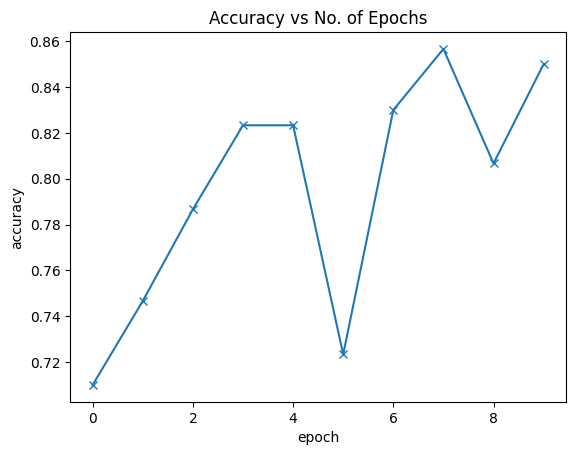

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x.get('val_loss') for x in history]
  plt.plot(val_losses, '-rx')
  plt.plot(train_losses, '-bx')
  plt.xlabel('epoch')
  plt.ylabel(['Validation', 'Training'])
  plt.title('Loss vs NO. of Epochs')

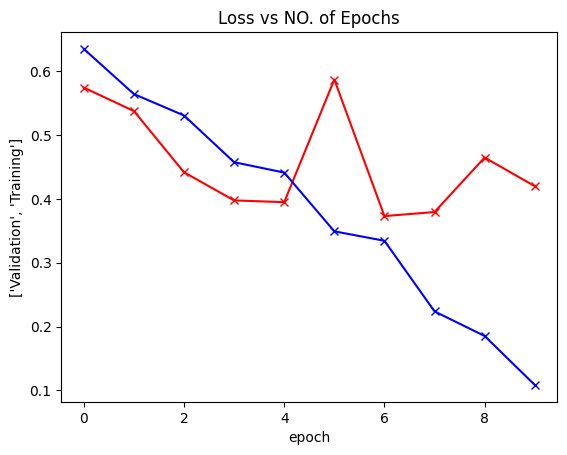

In [ ]:
plot_losses(history)

# Save and Test

In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/Corrosion_Detection.pth')

NameError: ignored

In [ ]:
import torch
import cv2
import torchvision.transforms as transforms

In [ ]:
def predict_single(image, model):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    # _, preds = torch.max(yb, dim = 1);
    # print(preds[0].item())
    # print("Prediction: ", prediction[0].item())
    prediction = preds[0]
    a = prediction[0].item()
    b = prediction[1].item()
    print(a, b);
    if a>b :
        print("Corrosion")
    else:
        print("No Corrosion")
    plt.imshow(image.cpu().permute(1, 2, 0))

In [ ]:
# path = '/content/drive/MyDrive/Corrosion_Detection.pth'
path = '/content/drive/My Drive/Corrosion_Detection.pth'
model = Corrosion_Detection()
model.load_state_dict(torch.load(path))
model = to_device(model, device)
model.eval()


Corrosion_Detection(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=200704, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(i

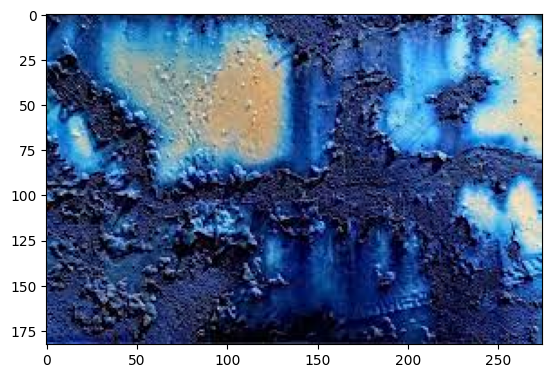

In [ ]:
# image = cv2.imread('drive/MyDrive/download/rust/rust.51.jpg')
image = cv2.imread('/content/download(2).jpeg')
# print(type(image))
plt.imshow(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
og_image = image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256)),
        transforms.CenterCrop(size=224),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])

])

tensor = transform(image)

0.4189346134662628 -0.31671378016471863
Corrosion


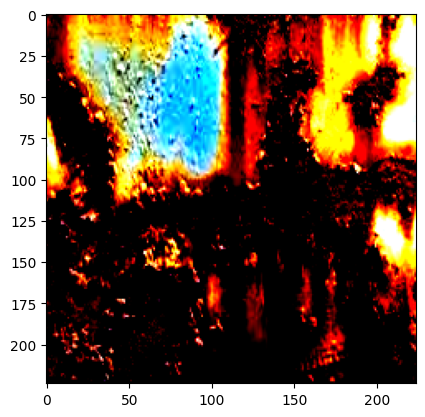

In [ ]:
# predict_single(test_ds[10][0])
# predict_single(tensor)
# test_dataset = to_device(test_dataset, device)
tensor = tensor.to(device)
predict_single(tensor, model)